# Advanced Cyberbullying Detection

In [56]:
# Imports
import os
import random
from pathlib import Path

import re
import unicodedata
import html
import string
import contractions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

import torch

from wordcloud import WordCloud

# NLTK
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

# Warnings
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Seed
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\emrev\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# GPU Availability
print("GPU available:", torch.cuda.is_available())

GPU available: True


## Loading Dataset

**Load Dataset**:

In [3]:
DATA_DIR = Path("../dataset")

# Check available datasets
csv_paths = sorted(DATA_DIR.glob("*.csv"))

print("Found CSVs:", len(csv_paths))
for f in csv_paths:
    print(f.name)

Found CSVs: 9
aggression_parsed_dataset.csv
attack_parsed_dataset.csv
cyberbullying_tweets.csv
kaggle_parsed_dataset.csv
toxicity_parsed_dataset.csv
twitter_parsed_dataset.csv
twitter_racism_parsed_dataset.csv
twitter_sexism_parsed_dataset.csv
youtube_parsed_dataset.csv


In [4]:
# Read dfs
dfs = {}

for f in csv_paths:
    path = DATA_DIR / f
    dfs[f] = pd.read_csv(path)
    print(f"{f}: shape={dfs[f].shape}")

..\dataset\aggression_parsed_dataset.csv: shape=(115864, 5)
..\dataset\attack_parsed_dataset.csv: shape=(115864, 5)
..\dataset\cyberbullying_tweets.csv: shape=(47692, 2)
..\dataset\kaggle_parsed_dataset.csv: shape=(8799, 4)
..\dataset\toxicity_parsed_dataset.csv: shape=(159686, 5)
..\dataset\twitter_parsed_dataset.csv: shape=(16851, 5)
..\dataset\twitter_racism_parsed_dataset.csv: shape=(13471, 5)
..\dataset\twitter_sexism_parsed_dataset.csv: shape=(14881, 5)
..\dataset\youtube_parsed_dataset.csv: shape=(3464, 10)


In [5]:
# Check Columns
for fname, df in dfs.items():
    print(f"{fname}, Columns: {df.columns}")

..\dataset\aggression_parsed_dataset.csv, Columns: Index(['index', 'Text', 'ed_label_0', 'ed_label_1', 'oh_label'], dtype='str')
..\dataset\attack_parsed_dataset.csv, Columns: Index(['index', 'Text', 'ed_label_0', 'ed_label_1', 'oh_label'], dtype='str')
..\dataset\cyberbullying_tweets.csv, Columns: Index(['tweet_text', 'cyberbullying_type'], dtype='str')
..\dataset\kaggle_parsed_dataset.csv, Columns: Index(['index', 'oh_label', 'Date', 'Text'], dtype='str')
..\dataset\toxicity_parsed_dataset.csv, Columns: Index(['index', 'Text', 'ed_label_0', 'ed_label_1', 'oh_label'], dtype='str')
..\dataset\twitter_parsed_dataset.csv, Columns: Index(['index', 'id', 'Text', 'Annotation', 'oh_label'], dtype='str')
..\dataset\twitter_racism_parsed_dataset.csv, Columns: Index(['index', 'id', 'Text', 'Annotation', 'oh_label'], dtype='str')
..\dataset\twitter_sexism_parsed_dataset.csv, Columns: Index(['index', 'id', 'Text', 'Annotation', 'oh_label'], dtype='str')
..\dataset\youtube_parsed_dataset.csv, Colu

**Clean Dataset**:

In [6]:
# Drop the unwanted columns and rename the column names
cleaned_dfs = {}

for fname, df in dfs.items():
    # Get the text column
    if "tweet_text" in df.columns:
        text_col = "tweet_text"
    else:
        text_col = "Text"

    # Get the label column
    if "cyberbullying_type" in df.columns:
        label_col = "cyberbullying_type"
    else:
        label_col = "oh_label"

    # Keep the columns and rename
    out = df[[text_col, label_col]].copy()
    out = out.rename(columns={text_col: "text", label_col: "is_cyberbullying"})

    # Assign the cleaned dfs
    cleaned_dfs[fname] = out

In [7]:
# Check Columns
for fname, df in cleaned_dfs.items():
    print(f"{fname}, Columns: {df.columns}")

..\dataset\aggression_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\attack_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\cyberbullying_tweets.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\kaggle_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\toxicity_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\twitter_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\twitter_racism_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\twitter_sexism_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\youtube_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')


**Combine Dfs**:

In [8]:
# Combine all
df = pd.concat(cleaned_dfs.values(), ignore_index=True)

print("DF Shape:", df.shape)

DF Shape: (496572, 2)


In [9]:
df.head()

,text,is_cyberbullying
0,`- This is not ``creative``. Those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"True or false, the situation as of March 200...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0


## Data Preparation

In [10]:
# Unique values in label
df['is_cyberbullying'].unique()

array([0, 1, 'not_cyberbullying', 'gender', 'religion',
       'other_cyberbullying', 'age', 'ethnicity', nan], dtype=object)

In [11]:
# Label Values
cyberbullying = [1, 'gender', 'religion', 'other_cyberbullying', 'age', 'ethnicity']
not_cyberbullying = [0, 'not_cyberbullying']

# Conditions
def convert_binary(label):
    # Check if in cyberbullying
    if label in cyberbullying:
        return 1

    # Check if in not_cyberbullying
    if label in not_cyberbullying:
        return 0

    # NaN case
    return None

df['is_cyberbullying'] = df['is_cyberbullying'].apply(convert_binary)

In [12]:
# Unique values in label
df['is_cyberbullying'].unique()

array([ 0.,  1., nan])

**Drop NaN Values**:

In [13]:
df = df.dropna(subset=["is_cyberbullying"]).reset_index(drop=True)
df["is_cyberbullying"] = df["is_cyberbullying"].astype(int)

In [14]:
df["is_cyberbullying"].unique()

array([0, 1])

In [15]:
print("Missing text:", df["text"].isna().sum())
print("Missing labels:", df["is_cyberbullying"].isna().sum())

Missing text: 0
Missing labels: 0


In [16]:
# Check the distribution of the label
df["is_cyberbullying"].value_counts(normalize=True)

is_cyberbullying
0    0.803857
1    0.196143
Name: proportion, dtype: float64

**Dublicated and Conflicted Values**:

In [17]:
# Dublicates
df['text'].duplicated().sum()

np.int64(235829)

In [18]:
# Dublicates on distribution
duplicates = df[df.duplicated(subset=["text", "is_cyberbullying"], keep=False)]
duplicates["is_cyberbullying"].value_counts()

is_cyberbullying
0    304770
1     53465
Name: count, dtype: int64

In [19]:
dup_conflict = df.groupby("text")["is_cyberbullying"].nunique()
conflicting = dup_conflict[dup_conflict > 1]

len(conflicting)

10105

In [20]:
# Remove conflicting values
conflicting_texts = (
    df.groupby("text")["is_cyberbullying"]
      .nunique()
)
conflicting_texts = conflicting_texts[conflicting_texts > 1].index

df = df[~df["text"].isin(conflicting_texts)]

# Remove duplicates
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)

print("Final dataset size:", len(df))
print("\nNew class distribution:")
print(df["is_cyberbullying"].value_counts(normalize=True))

Final dataset size: 250632

New class distribution:
is_cyberbullying
0    0.788187
1    0.211813
Name: proportion, dtype: float64


## Explatory Data Analysis

In [21]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (250632, 2)


,text,is_cyberbullying
0,`- This is not ``creative``. Those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"True or false, the situation as of March 200...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0


**Class Distribution**:

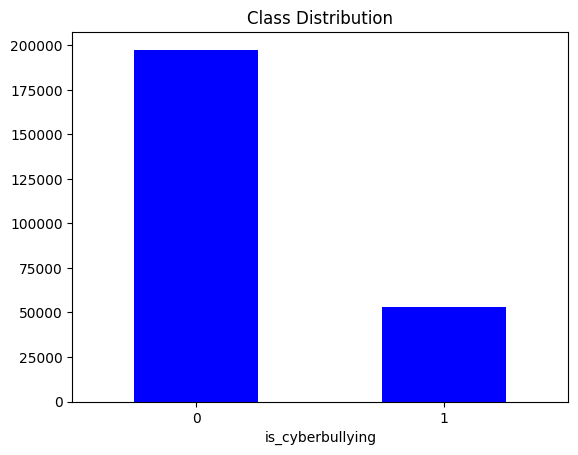

In [22]:
df["is_cyberbullying"].value_counts().plot(kind="bar", color='blue')
plt.title("Class Distribution")
plt.xticks(rotation=0)
plt.show()

In [23]:
# Text Length Analysis
df['text_length'] = df['text'].apply(len)
df['text_length'].describe()

count    250632.000000
mean        368.610042
std         655.293034
min           1.000000
25%          92.000000
50%         178.000000
75%         368.000000
max       20030.000000
Name: text_length, dtype: float64

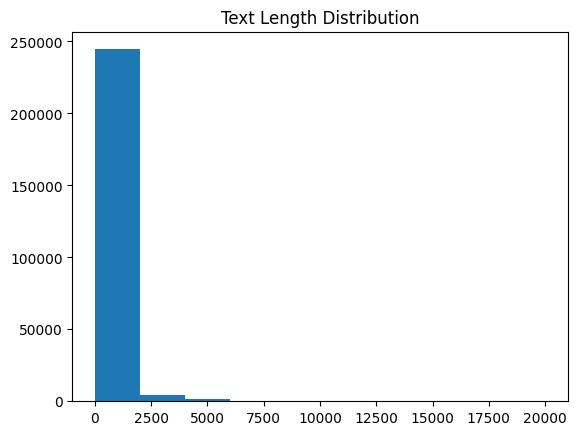

In [24]:
plt.hist(df["text_length"], bins=10)
plt.title("Text Length Distribution")
plt.show()

In [25]:
# Percentiles
df['text_length'].quantile([0.5, 0.9, 0.95, 0.99])

0.50     178.00
0.90     797.00
0.95    1270.00
0.99    3502.69
Name: text_length, dtype: float64

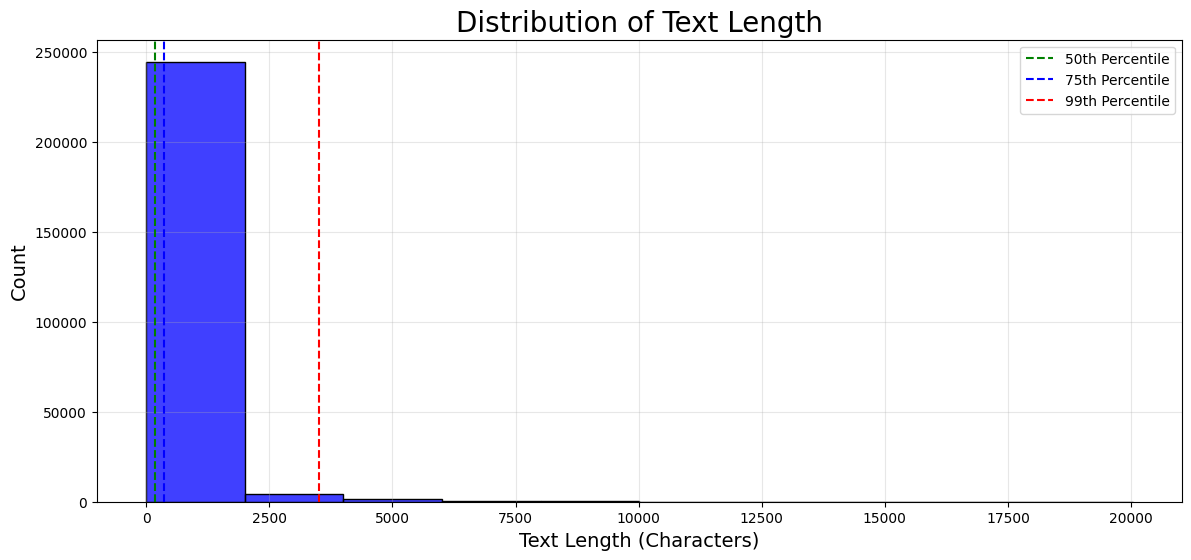

In [26]:
plt.figure(figsize=(14,6))

ax = sns.histplot(df['text_length'], bins=10, kde=False, color='blue')

plt.title('Distribution of Text Length', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Text Length (Characters)', fontsize=14)

# Calculate percentiles
q2 = np.percentile(df['text_length'], 50)
q3 = np.percentile(df['text_length'], 75)
q4 = np.percentile(df['text_length'], 99)

# Add percentile lines
plt.axvline(q2, color='green', linestyle='--', label='50th Percentile')
plt.axvline(q3, color='blue', linestyle='--', label='75th Percentile')
plt.axvline(q4, color='red', linestyle='--', label='99th Percentile')

plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [27]:
# Word Count
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['word_count'].describe()

count    250632.000000
mean         62.912338
std         111.061541
min           0.000000
25%          16.000000
50%          31.000000
75%          63.000000
max        2832.000000
Name: word_count, dtype: float64

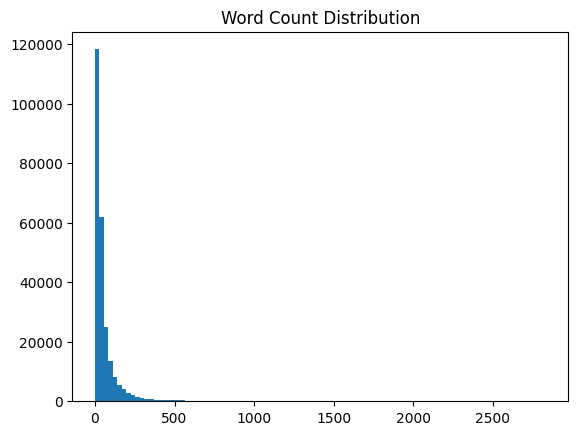

In [28]:
plt.hist(df["word_count"], bins=100)
plt.title("Word Count Distribution")
plt.show()

In [29]:
df[df["word_count"] < 3].head(10)

,text,is_cyberbullying,text_length,word_count
259,Err:510,0,7,1
370,:No problem.,0,16,2
472,Non-sequiter.,0,18,1
477,:::Picture removed.,0,22,2
504,:Wow.,0,9,1
614,* Keep.,0,10,2
628,:No clue.,0,13,2
919,,0,7,0
1476,` `,0,7,2
1725,Done!,0,10,1


In [30]:
len(df[df["word_count"] < 3])

1016

In [31]:
# Drop short texts
df = df[df["word_count"] >= 3].reset_index(drop=True)

In [32]:
len(df[df["word_count"] < 3])

0

In [33]:
# Top Words
def get_top_words(text_series, n=20):
    words = " ".join(text_series).lower().split()
    return Counter(words).most_common(n)

top_words_0 = get_top_words(df[df["is_cyberbullying"] == 0]["text"])
top_words_1 = get_top_words(df[df["is_cyberbullying"] == 1]["text"])

print("Top words (Non-cyberbullying):")
print(top_words_0[:20])

print("\nTop words (Cyberbullying):")
print(top_words_1[:20])


Top words (Non-cyberbullying):
[('the', 631173), ('to', 372244), ('of', 283044), ('and', 271688), ('a', 261764), ('i', 231558), ('is', 213325), ('you', 203377), ('that', 185917), ('in', 181258), ('it', 140261), ('for', 129873), ('this', 112978), ('not', 110301), ('on', 110267), ('be', 106194), ('`', 99495), ('as', 94704), ('have', 88843), ('==', 87692)]

Top words (Cyberbullying):
[('you', 59839), ('the', 51344), ('a', 49687), ('i', 43458), ('to', 37433), ('and', 37173), ('is', 28004), ('of', 26241), ('fuck', 22187), ('in', 22005), ('are', 17949), ('that', 17161), ('your', 16019), ('my', 13370), ('for', 12715), ('it', 11991), ('==', 11551), ('not', 11350), ('this', 11287), ('nigger', 10688)]


In [34]:
# NGrams Analysis
def top_ngrams(texts, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(texts)
    sums = X.sum(axis=0)
    words_freq = [(word, sums[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

print("Top bigrams (Cyberbullying):")
print(top_ngrams(df[df["is_cyberbullying"] == 1]["text"]))


Top bigrams (Cyberbullying):
[('fuck fuck', np.int64(7249)), ('nigger nigger', np.int64(5903)), ('high school', np.int64(4728)), ('hate hate', np.int64(4414)), ('jew fat', np.int64(3708)), ('shit shit', np.int64(3692)), ('fat jew', np.int64(3684)), ('ass ass', np.int64(3425)), ('penis penis', np.int64(2921)), ('faggot faggot', np.int64(2900)), ('wanker wanker', np.int64(2390)), ('nipple nipple', np.int64(2186)), ('dickhead dickhead', np.int64(2163)), ('suck suck', np.int64(2138)), ('die fag', np.int64(1875)), ('fag die', np.int64(1873)), ('fuck yourselfgo', np.int64(1866)), ('yourselfgo fuck', np.int64(1866)), ('freedom freedom', np.int64(1729)), ('dumb ass', np.int64(1604))]


In [35]:
# Sentiment Analysis
sia = SentimentIntensityAnalyzer()

df["sentiment"] = df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [36]:
df.groupby("is_cyberbullying")["sentiment"].describe()

,count,mean,std,min,25%,50%,75%,max
is_cyberbullying,,,,,,,,
0,196888.0,0.161418,0.542245,-1.0,-0.199325,0.0772,0.6369,1.0
1,52728.0,-0.371887,0.546080,-1.0,-0.836625,-0.5514,0.0000,1.0


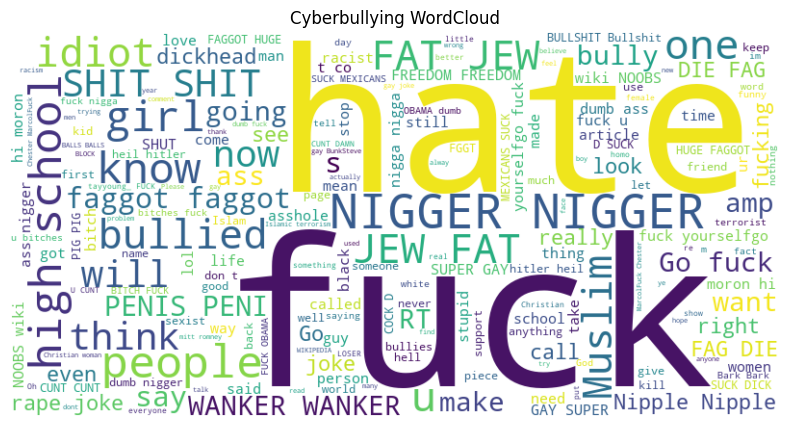

In [37]:
# WordCloud for Cyberbullying
text_1 = " ".join(df[df["is_cyberbullying"] == 1]["text"])

wc = WordCloud(width=800, height=400, background_color='white').generate(text_1)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Cyberbullying WordCloud")
plt.show()

In [38]:
# Long text Analysis
long_texts = df[df["text_length"] > 3000]

long_texts["is_cyberbullying"].value_counts()

is_cyberbullying
0    2844
1     422
Name: count, dtype: int64

## Data Cleaning

In [39]:
def preprocess_text(text):
    # Ensure string
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    if not text or text.isspace():
        return ""

    # Decode HTML entities
    text = html.unescape(text)

    # Normalize unicode
    text = unicodedata.normalize('NFKC', text)

    # Expand contractions (e.g., don't → do not)
    text = contractions.fix(text)

    # Replace URLs
    text = re.sub(r'https?://\S+|www\.\S+', '[URL]', text)

    # Replace emails
    text = re.sub(r'\S+@\S+', '[EMAIL]', text)

    # Replace phone numbers
    text = re.sub(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', '[PHONE]', text)

    # Replace mentions
    text = re.sub(r'@\w+', '[USER]', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub(r'(?:^|\s)([=:`]{3,})(?:\s|$)', ' ', text)

    return text

df['text'] = df['text'].apply(preprocess_text)

In [40]:
df.head()

,text,is_cyberbullying,text_length,word_count,sentiment
0,`- This is not ``creative``. Those are the dic...,0,2397,386,-0.9913
1,` :: the term ``standard model`` is itself les...,0,713,123,0.7015
2,"True or false, the situation as of March 2002 ...",0,329,59,0.7430
3,"Next, maybe you could work on being less conde...",0,429,75,-0.1426
4,This page will need disambiguation.,0,36,5,0.0000


## Model Training

**Train-Validation-Test Split**:

In [41]:
# First split: train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    df["text"],
    df["is_cyberbullying"],
    test_size=0.2,
    random_state=42,
    stratify=df["is_cyberbullying"]
)

# Second split: validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

print("\nTrain distribution:")
print(y_train.value_counts(normalize=True))

Train size: 199692
Validation size: 24962
Test size: 24962

Train distribution:
is_cyberbullying
0    0.788765
1    0.211235
Name: proportion, dtype: float64


**Model Creation**:

In [42]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 256

In [43]:
from datasets import Dataset

train_dataset = Dataset.from_dict({
    "text": X_train.tolist(),
    "label": y_train.tolist()
})

val_dataset = Dataset.from_dict({
    "text": X_val.tolist(),
    "label": y_val.tolist()
})

test_dataset = Dataset.from_dict({
    "text": X_test.tolist(),
    "label": y_test.tolist()
})


In [44]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/199692 [00:00<?, ? examples/s]

Map:   0%|          | 0/24962 [00:00<?, ? examples/s]

Map:   0%|          | 0/24962 [00:00<?, ? examples/s]

In [45]:
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [46]:
classes = np.unique(y_train)

weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights = dict(zip(classes, weights))

print(class_weights)

{np.int64(0): np.float64(0.633902609358136), np.int64(1): np.float64(2.367028590394007)}


**Training**:

In [47]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [50]:
import evaluate

# Metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
roc_auc = evaluate.load("roc_auc")

def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    probs = softmax(logits)[:, 1]

    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"],
        "auc": roc_auc.compute(prediction_scores=probs, references=labels)["roc_auc"],
    }

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,

    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=2000,
    save_steps=2000,

    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [51]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Auc
2000,0.131864,0.162612,0.949523,0.875617,0.984790
4000,0.121461,0.132836,0.954611,0.890394,0.988333
6000,0.112706,0.118919,0.956414,0.893584,0.989829
8000,0.093277,0.118134,0.958016,0.899866,0.990112
10000,0.108906,0.113669,0.958096,0.901895,0.990506
12000,0.117442,0.108530,0.963104,0.912311,0.991437
14000,0.089280,0.121991,0.961221,0.908886,0.991170
16000,0.077089,0.124864,0.962263,0.911383,0.991439
18000,0.070031,0.120650,0.962944,0.911559,0.991792
20000,0.074457,0.129818,0.963985,0.913732,0.991958


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=24962, training_loss=0.10438757359757082, metrics={'train_runtime': 5643.7347, 'train_samples_per_second': 70.766, 'train_steps_per_second': 4.423, 'total_flos': 5.254117286694912e+16, 'train_loss': 0.10438757359757082, 'epoch': 2.0})

In [52]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.12436391413211823,
 'eval_accuracy': 0.963624709558529,
 'eval_f1': 0.9138683361790931,
 'eval_auc': 0.9920527188488372,
 'eval_runtime': 70.2246,
 'eval_samples_per_second': 355.459,
 'eval_steps_per_second': 11.121,
 'epoch': 2.0}

In [53]:
pred = trainer.predict(test_dataset)
logits = pred.predictions
y_pred = np.argmax(logits, axis=1)
y_true = pred.label_ids

print(classification_report(y_true, y_pred, digits=4))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0     0.9768    0.9770    0.9769     19689
           1     0.9142    0.9135    0.9139      5273

    accuracy                         0.9636     24962
   macro avg     0.9455    0.9453    0.9454     24962
weighted avg     0.9636    0.9636    0.9636     24962

[[19237   452]
 [  456  4817]]


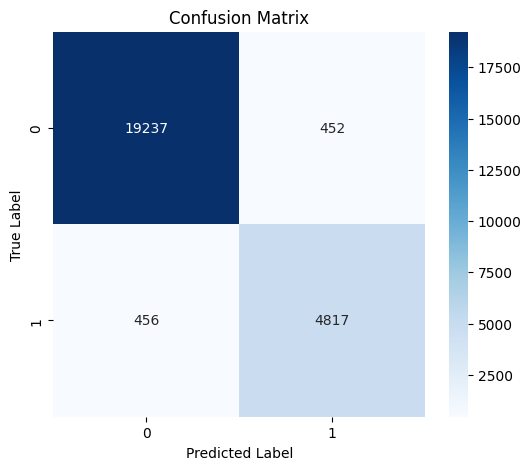

In [55]:
# Get predictions
pred = trainer.predict(test_dataset)
logits = pred.predictions
y_pred = np.argmax(logits, axis=1)
y_true = pred.label_ids

# Compute confusion matrix dynamically
cm = confusion_matrix(y_true, y_pred)

# Get unique class labels automatically
classes = np.unique(y_true)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

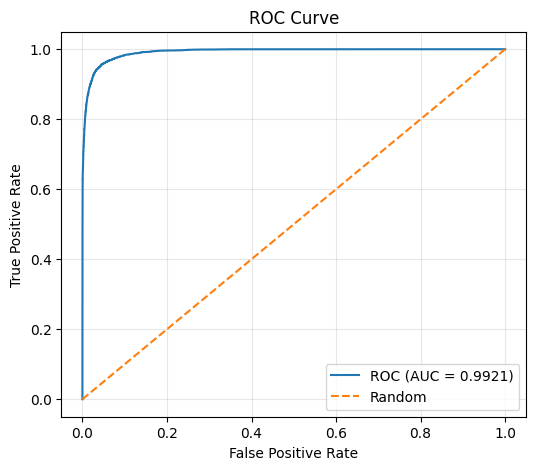

AUC (roc_auc_score): 0.9920527188488372


In [57]:
exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
y_score = probs[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("AUC (roc_auc_score):", roc_auc_score(y_true, y_score))

In [54]:
trainer.save_model("../models/bert_cyberbullying")
tokenizer.save_pretrained("../models/bert_cyberbullying")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('../models/bert_cyberbullying\\tokenizer_config.json',
 '../models/bert_cyberbullying\\tokenizer.json')